# Benchmark position-aware graph neural network/2D CNN architecture

This notebook contains all of the code to overfit a P-GNN/2D CNN to four contact channels of a single structure (6E6O).

## Setup



### Dataloader code 

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import periodictable as pt
import pandas as pd
import os
import matplotlib.pyplot as plt

def read_files(acc, model, graph_dir, contacts_dir):
    """
    Read graph and contacts files.
    
    Args:
    - acc (str) - String of the PDB ID (lowercese).
    - model (int) - Model number of the desired bioassembly.
    - graph_dir (str) - Directory containing the nodes, edges,
        and mask files.
    - contacts_dir (str) - Directory containing the .contacts
        files from get_contacts.py.
        
    Returns:
    - Dictionary of DataFrames and lists corresponding to
        graph nodes, edges, mask, and contacts. 
    """

    # Get the file names for the graph files
    node_file = os.path.join(graph_dir, '{}-{}_nodes.csv'.format(acc, model))
    edge_file = os.path.join(graph_dir, '{}-{}_edges.csv'.format(acc, model))
    mask_file = os.path.join(graph_dir, '{}-{}_mask.csv'.format(acc, model))

    # Get the contacts file
    contacts_file = os.path.join(contacts_dir, '{}-{}.contacts'.format(acc, model))

    # Read the nodes and edges
    nodes = pd.read_csv(node_file)
    edges = pd.read_csv(edge_file)

    # Check if the mask is empty
    if os.path.getsize(mask_file) > 0:
        with open(mask_file) as f:
            mask = f.read().split('\n')
    else:
        mask = []

    # Read the contacts
    contacts = pd.read_table(contacts_file, sep='\t',
                             header=None, names=['type', 'start', 'end'])

    # Return the data
    data = {
        'nodes': nodes,
        'edges': edges,
        'mask': mask,
        'contacts': contacts
    }

    return data
    
    
def process_res_data(data):
    """
    Process residue-level data from atom-level data.
    
    Args:
    - data (dict) - Dictionary of graph data output from `read_files`.
    
    Returns:
    - Dictionary of atom and residue graph and contact data.
    """

    # Extract data form dict
    nodes = data['nodes']
    edges = data['edges']
    mask = data['mask']
    contacts = data['contacts']

    # Get residue nodes
    res_nodes = pd.DataFrame()
    res_nodes['res'] = [':'.join(atom.split(':')[:3]) for atom in nodes['atom']]
    res_nodes = res_nodes.drop_duplicates().reset_index(drop=True)

    # Get residue edges
    res_edges = edges.copy()
    res_edges['start'] = [':'.join(atom.split(':')[:3]) for atom in res_edges['start']]
    res_edges['end'] = [':'.join(atom.split(':')[:3]) for atom in res_edges['end']]
    res_edges = res_edges[res_edges['start'] != res_edges['end']].drop_duplicates().reset_index(drop=True)

    # Get residue contacts
    res_contacts = contacts.copy()
    res_contacts['start'] = [':'.join(atom.split(':')[:3]) for atom in res_contacts['start']]
    res_contacts['end'] = [':'.join(atom.split(':')[:3]) for atom in res_contacts['end']]
    res_contacts = res_contacts[res_contacts['start'] != res_contacts['end']].drop_duplicates().reset_index(drop=True)

    # Get residue mask
    res_mask = list(set([':'.join(atom.split(':')[:3]) for atom in mask]))

    # Return data dict
    data = {
        'atom_nodes': nodes,
        'atom_edges': edges,
        'atom_contact': contacts,
        'atom_mask': mask,
        'res_nodes': res_nodes,
        'res_edges': res_edges,
        'res_contact': res_contacts,
        'res_mask': res_mask
    }

    return data


def get_map_dicts(entity_list):
    """
    Map identifiers to indices and vice versa.
    
    Args:
    - entity_list (list) - List of entities (atoms, residues, etc.)
        to index.
    
    Returns:
    - Tuple of the entity to index and index to entity dicts, respectively.
    """
    
    # Create the entity:index dictionary
    ent2idx_dict = {entity: idx for idx, entity in enumerate(entity_list)}

    # Create the index:entity dictionary
    idx2ent_dict = {idx: entity for entity, idx in ent2idx_dict.items()}
    
    return (ent2idx_dict, idx2ent_dict)


def create_adj_mat(data, dict_map, mat_type):
    """
    Creates an adjacency matrix.
    
    Args:
    - data (DataFrame) - Dataframe with 'start' and 'end' column
        for each interaction. For atom-level adjacency, 'order' 
        column is also required. For atom or residue conatcts,
        'type' column is also required.
    
    Returns:
    - Coordinate format matrix (numpy). For atom adjacency, third column
        corresponds to bond order. For contacts, third column
        corresponds to channel.
    
    Channel mappings (shorthand from get_contacts.py source):

        0:
            hp             hydrophobic interactions
        1:
            hb             hydrogen bonds
            lhb            ligand hydrogen bonds
            hbbb           backbone-backbone hydrogen bonds
            hbsb           backbone-sidechain hydrogen bonds
            hbss           sidechain-sidechain hydrogen bonds
            hbls           ligand-sidechain residue hydrogen bonds
            hblb           ligand-backbone residue hydrogen bonds
        2:
            vdw            van der Waals
        3:
            wb             water bridges
            wb2            extended water bridges
            lwb            ligand water bridges
            lwb2           extended ligand water bridges
        4:
            sb             salt bridges
        5:
            ps             pi-stacking
        6:
            pc             pi-cation
        7:
            ts             t-stacking
    """
    
    # Initialize the coordinate list
    coord_mat = []

    # Map channel names to numeric channels
    channel = {
        # Hydrophobic interactions in first channel
        'hp': 0,

        # Hydrogen bonds in second channel
        'hb': 1,
        'lhb': 1, 
        'hbbb': 1,
        'hbsb': 1,
        'hbss': 1,
        'hbls': 1,
        'hblb': 1,

        # VdW in third channel
        'vdw': 2,

        # Water bridges
        'wb': 3, 
        'wb2': 3,
        'lwb': 3,
        'lwb2': 3,

        # Salt bridges
        'sb': 4,

        # Other interactions
        'ps': 5,
        'pc': 6,
        'ts': 7,
    }

    # Assemble the contacts
    for idx, row in data.iterrows():

        entry = [dict_map[row['start']], dict_map[row['end']]]

        # Add order or type if necessary
        if mat_type == 'atom_graph':
            entry.append(row['order'])
        elif mat_type == 'atom_contact':
            entry.append(channel[row['type']])
        elif mat_type == 'res_contact':
            entry.append(channel[row['type']])

        coord_mat.append(entry)

    return(np.array(coord_mat))


def create_mem_mat(atom_dict, res_dict):
    """
    Create a membership matrix mapping atoms to residues.
    
    Args:
    - atom_dict (dict) - Dictionary mapping atoms to indices.
    - res_dict (dict) - Dictionary mapping residues to indices.
    
    Returns:
    - Coordinate format membership matrix (numpy) with first
        row being residue number and the second column being
        atom number.
    """
    
    # Initialize the coordinate list
    mem_coord = []
    
    # Map atoms to residues
    for atom, atom_idx in atom_dict.items():
        res_idx = res_dict[':'.join(atom.split(':')[:3])]
        
        mem_coord.append([res_idx, atom_idx])
        
    mem_coord = np.array(mem_coord)
    
    return mem_coord


def create_idx_list(id_list, dict_map):
    """
    Create list of indices.
    
    Args:
    - id_list (list) - List of masked atom or residue identifiers.
    - dict_map (dict) - Dictionary mapping entities to indices.
    
    Returns:
    - A numpy array of the masked indices.
    """
    
    # Generate the numpy index array
    idx_array = np.array([dict_map[iden] for iden in id_list])
    
    return idx_array


class TesselateDataset(Dataset):
    """
    Dataset class for structural data.
    
    Args:
    - accession_list (str) - File path from which to read PDB IDs for dataset.
    - graph_dir (str) - Directory containing the nodes, edges, and mask files.
    - contacts_dir (str) - Directory containing the .contacts files from
        get_contacts.py.
    - return_data (list) - List of datasets to return. Value must be 'all' or
        a subset of the following list:
            - pdb_id
            - model
            - atom_nodes
            - atom_adj
            - atom_contact
            - atom_mask
            - res_adj
            - res_contact
            - res_mask
            - mem_mat
            - idx2atom_dict
            - idx2res_dict    
    """
    
    def __init__(self, accession_list, graph_dir, contacts_dir, add_covalent=False, return_data='all', in_memory=False):
        
        if return_data == 'all':
            self.return_data = [
                'pdb_id',
                'model',
                'atom_nodes',
                'atom_adj',
                'atom_contact',
                'atom_mask',
                'res_adj',
                'res_contact',
                'res_mask',
                'mem_mat',
                'idx2atom_dict',
                'idx2res_dict'
            ]
        
        # Store reference to accession list file
        self.accession_list = accession_list
        
        # Store references to the necessary directories
        self.graph_dir = graph_dir
        self.contacts_dir = contacts_dir
        
        # Whether to add covalent bonds to prediction task and
        # remove sequence non-deterministic covalent bonds from the adjacency matrix
        self.add_covalent=add_covalent
        
        # Read in and store a list of accession IDs
        with open(accession_list, 'r') as handle:
            self.accessions = np.array([acc.strip().lower().split() for acc in handle.readlines()])
            
        self.data = {}

            
    def __len__(self):
        """
        Return the length of the dataset.
        
        Returns:
        - Integer count of number of examples.
        """
        return len(self.accessions)
    
    
    def __getitem__(self, idx):
        """
        Get an item with a particular index value.
        
        Args:
        - idx (int) - Index of desired sample.
        
        Returns:
        - Dictionary of dataset example. All tensors are sparse when possible.
        """
        if idx in self.data:
            return self.data[idx]
        
        # initialize the return dictionary
        return_dict = {}
        
        acc_entry = self.accessions[idx]
        
        # Get the PDB ID
        acc = acc_entry[0]

        # Get the model number if one exists
        if len(acc_entry) == 1:
            model = 1
        else:
            model = acc_entry[1]
            
        # Read and process the files
        data = read_files(acc, model, self.graph_dir, self.contacts_dir)
        data = process_res_data(data)
        
        # Generate the mapping dictionaries
        atom2idx_dict, idx2atom_dict = get_map_dicts(data['atom_nodes']['atom'].unique())
        res2idx_dict, idx2res_dict = get_map_dicts(data['res_nodes']['res'].unique())
        
        # Get numbers of atoms and residues per sample
        n_atoms = len(atom2idx_dict)
        n_res = len(res2idx_dict)
        
        # Handle all of the possible returned datasets
        if 'pdb_id' in self.return_data:
            return_dict['pdb_id'] = acc
            
        if 'model' in self.return_data:
            return_dict['model'] = model
            
        if 'atom_nodes' in self.return_data:
            ele_nums = [pt.elements.symbol(element).number for element in data['atom_nodes']['element']]
            return_dict['atom_nodes'] = torch.LongTensor(ele_nums)
        
        if 'atom_adj' in self.return_data:
            adj = create_adj_mat(data['atom_edges'], atom2idx_dict, mat_type='atom_graph').T
            
            x = torch.LongTensor(adj[0, :]).squeeze()
            y = torch.LongTensor(adj[1, :]).squeeze()
            val = torch.FloatTensor(adj[2, :]).squeeze()
            
            atom_adj = torch.zeros([n_atoms, n_atoms]).index_put_((x, y), val, accumulate=False)
            
            atom_adj = atom_adj.index_put_((y, x), val, accumulate=False)
            
            atom_adj[range(n_atoms), range(n_atoms)] = 1
            
            atom_adj = (atom_adj > 0).float()
            
            return_dict['atom_adj'] = atom_adj
            
        if 'atom_contact' in self.return_data:
            atom_contact = create_adj_mat(data['atom_contact'], atom2idx_dict, mat_type='atom_contact').T
            
            x = torch.LongTensor(atom_contact[0, :]).squeeze()
            y = torch.LongTensor(atom_contact[1, :]).squeeze()
            z = torch.LongTensor(atom_contact[2, :]).squeeze()

            atom_contact = torch.zeros([n_atoms, n_atoms, 8]).index_put_((x, y, z),
                                                                    torch.ones(len(x)))
            atom_contact = atom_contact.index_put_((y, x, z), 
                                                   torch.ones(len(x)))
            
            return_dict['atom_contact'] = atom_contact
            
        if 'atom_mask' in self.return_data:
            atom_mask = create_idx_list(data['atom_mask'], atom2idx_dict)
            
            masked_pos = torch.from_numpy(atom_mask)
            
            if self.add_covalent:
                channels = 9
            else:
                channels = 8
            
            mask = torch.ones([n_atoms, n_atoms, channels])
            mask[masked_pos, :, :] = 0
            mask[:, masked_pos, :] = 0
            
            return_dict['atom_mask'] = mask
            
        if 'res_adj' in self.return_data:            
            adj = create_adj_mat(data['res_edges'], res2idx_dict, mat_type='res_graph').T
            
            x = torch.LongTensor(adj[0, :]).squeeze()
            y = torch.LongTensor(adj[1, :]).squeeze()
            
            res_adj = torch.zeros([n_res, n_res]).index_put_((x, y), torch.ones(len(x)))
            
            res_adj = res_adj.index_put_((y, x), torch.ones(len(x)))
            
            res_adj[range(n_res), range(n_res)] = 1
            
            return_dict['res_adj'] = res_adj
            
        if 'res_contact' in self.return_data:
            res_contact = create_adj_mat(data['res_contact'], res2idx_dict, mat_type='res_contact').T
            
            x = torch.LongTensor(res_contact[0, :]).squeeze()
            y = torch.LongTensor(res_contact[1, :]).squeeze()
            z = torch.LongTensor(res_contact[2, :]).squeeze()

            res_contact = torch.zeros([n_res, n_res, 8]).index_put_((x, y, z),
                                                                    torch.ones(len(x)))
            
            res_contact = res_contact.index_put_((y, x, z),
                                                 torch.ones(len(x)))
            
            return_dict['res_contact'] = res_contact
            
        if 'res_mask' in self.return_data:
            res_mask = create_idx_list(data['res_mask'], res2idx_dict)
            
            masked_pos = torch.from_numpy(res_mask)
            
            if self.add_covalent:
                channels = 9
            else:
                channels = 8
            
            mask = torch.ones([n_res, n_res, channels])
            mask[masked_pos, :, :] = 0
            mask[:, masked_pos, :] = 0
            
            return_dict['res_mask'] = mask
            
        if 'mem_mat' in self.return_data:
            mem_mat = create_mem_mat(atom2idx_dict, res2idx_dict).T
            
            x = torch.LongTensor(mem_mat[0, :]).squeeze()
            y = torch.LongTensor(mem_mat[1, :]).squeeze()
            
            mem_mat = torch.zeros([n_res, n_atoms]).index_put_((x, y),
                                                               torch.ones(len(x)))
            
            return_dict['mem_mat'] = mem_mat
            
        if 'idx2atom_dict' in self.return_data:
            return_dict['idx2atom_dict'] = idx2atom_dict
            
        if 'idx2res_dict' in self.return_data:
            return_dict['idx2res_dict'] = idx2res_dict
            
        self.data[idx] = return_dict
            
        # Return the processed data
        return return_dict

### Modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


####################
# Embedding layers #
####################

class AtomOneHotEmbed(nn.Module):
    """
    Create one-hot embeddings for atom identities.
    """
    def __init__(self):
        super(AtomOneHotEmbed, self).__init__()
        
        self.idx_map = {
            6: 0,
            7: 1,
            8: 2,
            15: 3,
            16: 4
        }
        
    def forward(self, atomic_numbers):
        """
        Return the embeddings for each atom in the graph.
        
        Args:
        - atoms (torch.LongTensor) - Tensor (n_atoms) containing atomic numbers.
        
        Returns:
        - torch.FloatTensor of dimension (n_atoms, n_features) containing
            the embedding vectors.
        """
        
        embedded_atoms = torch.zeros((len(atomic_numbers), 6),
                                     device=atomic_numbers.device)
        for i, j in enumerate(atomic_numbers):
            j = int(j)
            if j in self.idx_map:
                embedded_atoms[i, self.idx_map[j]] = 1
            else:
                embedded_atoms[i, 5] = 1
            
        return embedded_atoms


#########################
# Position-aware layers #
#########################

# # PGNN layer, only pick closest node for message passing
class PGNN_layer(nn.Module):
    def __init__(self, input_dim, output_dim,dist_trainable=False):
        super(PGNN_layer, self).__init__()
        self.input_dim = input_dim
        self.dist_trainable = dist_trainable

        if self.dist_trainable:
            self.dist_compute = Nonlinear(1, output_dim, 1)

        self.linear_hidden = nn.Linear(input_dim*2, output_dim)
        self.linear_out_position = nn.Linear(output_dim,1)
        self.act = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data = nn.init.constant_(m.bias.data, 0.0)

    def forward(self, feature, dists_max, dists_argmax):
        if self.dist_trainable:
            dists_max = self.dist_compute(dists_max.unsqueeze(-1)).squeeze()

        subset_features = feature[dists_argmax.flatten(), :]
        subset_features = subset_features.reshape((dists_argmax.shape[0], dists_argmax.shape[1],
                                                   feature.shape[1]))

        messages = subset_features * dists_max.unsqueeze(-1)

        self_feature = feature.unsqueeze(1).repeat(1, dists_max.shape[1], 1)
        messages = torch.cat((messages, self_feature), dim=-1)

        messages = self.linear_hidden(messages).squeeze()
        messages = self.act(messages) # n*m*d

        out_position = self.linear_out_position(messages).squeeze(-1)  # n*m_out
        out_structure = torch.mean(messages, dim=1)  # n*d

        return out_position, out_structure


### Non linearity
class Nonlinear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Nonlinear, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.act = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data = nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x


#################
# Custom losses #
#################

class FocalLoss(nn.Module):
    
    def __init__(self, gamma, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, preds, target):
        
        target_colsums = torch.sum(target, dim=0)
        alpha = target_colsums / target.shape[0]
        
        pos_mask = target == 1
        neg_mask = target == 0
        alpha_mat = torch.zeros(*target.shape, device=target.device)
        alpha_mat += (pos_mask * alpha.repeat(target.shape[0], 1))
        alpha_mat += (neg_mask * (1 - alpha).repeat(target.shape[0], 1))
        
        BCE_loss = F.binary_cross_entropy_with_logits(preds, target,
                                                      reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = alpha_mat * (1-pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            focal_loss = focal_loss.mean()
        elif self.reduction == 'sum':
            focal_loss = focal_loss.sum()
        
        return focal_loss

# Functions

In [3]:
import numpy as np
import torch

########################################
# Pairwise matrix generation functions #
########################################

def pairwise_mat(nodes, method='mean'):
    """
    Generate matrix for pairwise determination of interactions.
    
    Args:
    - nodes (torch.FloatTensor) - Tensor of node (n_nodes, n_features) features.
    - method (str) - One of 'sum' or 'mean' for combination startegy for
        pairwise combination matrix (default = 'mean').
        
    Returns:
    - torch.FloatTensor of shape (n_pairwise, n_nodes) than can be used used to
        combine feature vectors. Values are 1 if method == "sum" and 0.5 if
        method == "mean".
    """ 

    # Get the upper triangle indices
    triu = np.vstack(np.triu_indices(nodes.shape[0]))
    
    # Loop through all indices and add to list with 
    idxs = torch.from_numpy(triu).T
    
    # Convert to tensor
    combos = torch.zeros([idxs.shape[0], nodes.shape[0]]).scatter(1, idxs, 1)
    
    # Set to 0.5 if method is 'mean'
    if method == 'mean':
        combos *= 0.5
        
    return combos


def pairwise_3d(nodes):
    # Get the upper triangle indices
    repeated_nodes = nodes.unsqueeze(0).expand(nodes.shape[0], -1, -1)
    repeated_nodes2 = repeated_nodes.permute(1, 0, 2)
    
    return torch.cat((repeated_nodes, repeated_nodes2), dim=-1)


############################
# Upper triangle functions #
############################

def triu_condense(input_tensor):
    """
    Condense the upper triangle of a tensor into a 2d dense representation.
    
    Args:
    - input_tensor (torch.Tensor) - Tensor of shape (n, n, m).
    
    Returns:
    - Tensor of shape (n(n+1)/2, m) where elements along the third dimension in
        the original tensor are packed row-wise according to the upper
        triangular indices.
    """
    
    # Get upper triangle index info
    row_idx, col_idx = np.triu_indices(input_tensor.shape[0])
    row_idx = torch.LongTensor(row_idx)
    col_idx = torch.LongTensor(col_idx)
    
    # Return the packed matrix
    output = input_tensor[row_idx, col_idx, :]
    
    return output


def triu_expand(input_matrix):
    """
    Expand a dense representation of the upper triangle of a tensor into 
    a 3D squareform representation.
    
    Args:
    - input_matrix (torch.Tensor) - Tensor of shape (n(n+1)/2, m).
    
    Returns:
    - Tensor of shape (n, n, m) where elements along the third dimension in the
        original tensor are packed row-wise according to the upper triangular
        indices.
    """
    # Get the edge size n of the tensor
    n_elements = input_matrix.shape[0]
    n_chan = input_matrix.shape[1]
    n_res = int((-1 + np.sqrt(1 + 4 * 2 * (n_elements))) / 2)
    
    # Get upper triangle index info
    row_idx, col_idx = np.triu_indices(n_res)
    row_idx = torch.LongTensor(row_idx)
    col_idx = torch.LongTensor(col_idx)
    
    # Generate the output tensor
    output = torch.zeros((n_res, n_res, n_chan))
    
    # Input the triu values
    for i in range(n_chan):
        i_tens = torch.full((len(row_idx),), i, dtype=torch.long)
        output.index_put_((row_idx, col_idx, i_tens), input_matrix[:, i])
    
    # Input the tril values
    for i in range(n_chan):
        i_tens = torch.full((len(row_idx),), i, dtype=torch.long)
        output.index_put_((col_idx, row_idx, i_tens), input_matrix[:, i])
    
    return output


###################
# P-GNN functions #
###################

def generate_dists(adj_mat):
    adj_mask = adj_mat == 0
    
    dist = adj_mat - torch.eye(adj_mat.shape[0], device=adj_mat.device)
    dist = 1 / (dist + 1)
    dist[adj_mask] = 0
    
    return dist.squeeze()


def get_dist_max(anchorset_id, dist):
    dist_max = torch.zeros((dist.shape[0],len(anchorset_id)),
                           device=dist.device)
    dist_argmax = torch.zeros((dist.shape[0],len(anchorset_id)),
                              device=dist.device).long()
    for i in range(len(anchorset_id)):
        temp_id = anchorset_id[i]
        dist_temp = dist[:, temp_id]
        dist_max_temp, dist_argmax_temp = torch.max(dist_temp, dim=-1)
        dist_max[:,i] = dist_max_temp
        dist_argmax[:,i] = dist_argmax_temp
    return dist_max, dist_argmax


def get_random_anchorset(n,c=0.5):
    m = int(np.log2(n))
    copy = int(c*m)
    anchorset_id = []
    for i in range(m):
        anchor_size = int(n/np.exp2(i + 1))
        for j in range(copy):
            anchorset_id.append(np.random.choice(n,size=anchor_size,replace=False))
    return anchorset_id


def preselect_anchor(n_nodes, dists):
    anchorset_id = get_random_anchorset(n_nodes, c=1)
    return get_dist_max(anchorset_id, dists)

### Model

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class PGNN2D(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 anchorset_n, n_contact_channels, 
                 layer_num=2, train_data=None,
                 val_data=None, test_data=None):
        super(PGNN2D, self).__init__()
        
        # Parameters
        self.n_contact_channels = n_contact_channels
        self.layer_num = layer_num
        
        # Datasets
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        # Embedding
        self.embed = AtomOneHotEmbed()
        
        # First P-GNN layer
        self.conv_atom_first = PGNN_layer(input_dim, hidden_dim)

        # All other P-GNN layers
        if layer_num>1:
            self.conv_atom_hidden = nn.ModuleList([PGNN_layer(hidden_dim,
                                                              hidden_dim)
                                                  for i in range(layer_num - 1)])
        
        # 2D convolutional layers
        self.conv1 = nn.Conv2d(anchorset_n * 2,
                               25, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(25,
                               25, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(25,
                               25, 3, stride=1, padding=1)
        
        # Final 2D CNN
        self.conv_final = nn.Conv2d(25, n_contact_channels, 3, stride=1, padding=1)
        
        # Focal loss
        self.loss = FocalLoss(3, reduction='sum')
        
        self.activations = {}


    def forward(self, data):
        
        data['atom_dist'] = generate_dists(data['atom_adj'])

        data['atom_dist_max'], data['atom_dist_argmax'] = preselect_anchor(data['atom_adj'].squeeze().shape[0], data['atom_dist'])

        x = self.embed(data['atom_nodes'].squeeze())
        
        atom_embed = x.detach().cpu().numpy()
        
        x_position, x = self.conv_atom_first(x, data['atom_dist_max'], data['atom_dist_argmax'])
        x = F.relu(x)
            
        for i in range(self.layer_num-1):
            
            data['atom_dist'] = generate_dists(data['atom_adj'])

            data['atom_dist_max'], data['atom_dist_argmax'] = preselect_anchor(data['atom_adj'].squeeze().shape[0], data['atom_dist'])
            
            x_position, x = self.conv_atom_hidden[i](x, data['atom_dist_max'], data['atom_dist_argmax'])
            x = F.relu(x)
            
        atom_embed_update = x_position.detach().cpu().numpy()
            
        x_position = data['mem_mat'].squeeze().matmul(x_position)
        
        res_embed = x_position.detach().cpu().numpy()
        res_embed.shape
        
        pairwise = pairwise_3d(x_position).permute(2, 0, 1).unsqueeze(0)
        
        conv1_out = F.relu(self.conv1(pairwise))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        square_preds = self.conv_final(conv3_out)
        
        square_preds = square_preds + square_preds.permute(0, 1, 3, 2)
        
        preds = triu_condense(square_preds.squeeze().permute(1, 2, 0))
        
        self.activations = {
            'atom_embed': atom_embed,
            'atom_embed_update': atom_embed_update,
            'res_embed': res_embed,
            'combined': pairwise.detach().cpu().numpy(),
            'preds': preds.detach().cpu().numpy()
        }

        return preds
    
    def training_step(self, batch, batch_nb):
        y_hat = self.forward(batch)
        y = triu_condense(batch['res_contact'].squeeze())
        loss = self.loss(y_hat, y)
    
        return {'loss': loss}

    def configure_optimizers(self):        
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        return torch.optim.SGD(parameters, lr=1e-6, momentum=0.9)
    
    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.train_data, shuffle=True, num_workers=10, pin_memory=True)

/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tshimko/.virt

### Analysis functions

In [5]:
def plot_channels(values):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    
    ax = ax.flatten()
    
    channel_names = [
        'Hydrophobic',
        'Hydrogen bond',
        'Van der Waals',
        'Water bridges',
        'Salt bridges',
        'Pi-stacking',
        'Pi-cation',
        'T-stacking'
    ]
    
    for channel in range(preds.shape[-1]):
        ax[channel].imshow(values[:, :, channel].squeeze(), vmin=0, vmax=1)
        ax[channel].set(title=channel_names[channel], xlabel='Residue #', ylabel='Residue #')
                        
    fig.show()
    

######################
# ROC and PRC curves #
######################
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def calc_metric_curve(preds, target, curve_type, squareform=False):
    """
    Calculate ROC or PRC curves and area for the predicted contact channels.
    
    Args:
    - preds (np.ndarray) - Numpy array of model predictions either of form
        (n_res, n_res, n_chan) or (n_res * [n_res - 1] / 2, n_chan).
    - target (np.ndarray) - Numpy array of target values either of form
        (n_res, n_res, n_chan) or (n_res * [n_res - 1] / 2, n_chan),
        must match form of preds.
    - curve_type (str) - One of 'ROC' or 'PRC' to denote type of curve.
    - squareform (bool) - True if tensors are of shape (n_res, n_res, n_chan),
        False if they are of shape (n_res * [n_res - 1] / 2, n_chan)
        (default = True).
    
    Returns:
    - Tuple of x, y, and AUC values to be used for plotting the curves
        using plot_curve metric.
    """
    
    # Get correct curve function
    if curve_type.upper() == 'ROC':
        curve_func = roc_curve
    elif curve_type.upper() == 'PRC':
        curve_func = precision_recall_curve
        
    # Generate dicts to hold outputs from curve generation functions
    x = dict()
    y = dict()
    auc_ = dict()
    
    # Handle case of squareform matrix (only get non-redundant triu indices)
    if squareform:
        indices = np.triu_indices(target.shape[0])

    # For each channel
    for i in range(target.shape[-1]):
        
        # Handle case of squareform
        if squareform:
            var1, var2, _ = curve_func(target[:, :, i][indices],
                                       preds[:, :, i][indices])
            
        # Handle case of pairwise
        else:
            var1, var2, _ = curve_func(target[:, i], preds[:, i])
        
        # Assign outputs to correct dict for plotting
        if curve_type.upper() == 'ROC':
            x[i] = var1
            y[i] = var2
        elif curve_type.upper() == 'PRC':
            x[i] = var2
            y[i] = var1
        
        # Calc AUC
        auc_[i] = auc(x[i], y[i])
        
    return (x, y, auc_)


def plot_curve_metric(x, y, auc, curve_type, title=None, labels=None):
    """
    Plot ROC or PRC curves per output channel.
    
    Args:
    - x (dict) - Dict of numpy arrays for values to plot on x axis.
    - y (dict) - Dict of numpy arrays for values to plot on x axis.
    - auc (dict) - Dict of numpy arrays for areas under each curve.
    - curve_type (str) - One of 'ROC' or 'PRC' to denote type of curve.
    - title
    - labels
    
    Returns:
    - pyplot object of curves. 
    """
    
    # Generate figure
    plt.figure()
    
    # Linetype spec
    lw = 2
    curve_type = curve_type.upper()
    
    # Get the number of channels being plotted
    n_chan = len(x)
    
    # Make labels numeric if not provided
    if labels is None:
        labels = list(range(n_chan))
    
    # Check to make sure the labels are the right length
    if len(labels) != n_chan:
        raise ValueError('Number of labels ({}) does not match number of prediction channels ({}).'.format(len(labels), n_chan))
    
    # Get a lit of colors for all the channels
    color_list = plt.cm.Set1(np.linspace(0, 1, n_chan))
    
    # Plot each line
    for i, color in enumerate(color_list):
        plt.plot(x[i], y[i], color=color,
                 lw=lw, label='{} (area = {:0.2f})'.format(labels[i], auc[i]))
        
    # Add labels and diagonal line for ROC
    if curve_type == 'ROC':
        xlab = 'FPR'
        ylab = 'TPR'
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.legend(loc="lower right")

    # Add labels for PRC 
    elif curve_type == 'PRC':
        xlab = 'Recall'
        ylab = 'Precision'
        plt.legend(loc="lower left")
    
    # Extend limits, add labels and title
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    if title is not None:
        plt.title('{} for {}'.format(curve_type, title))
    else:
        plt.title('{}'.format(curve_type))
    
    plt.show()

def plot_curve(preds, target, curve_type, title=None, labels=None,
               squareform=False):
    """
    Wrapper to directly plot curves from model output and target.
    
    Args:
    - preds (np array-like) - Array or tensor of predicted values output by
        model.
    - target (np array-like) - Array or tensor of target values.
    - curve_type (str) - One of 'ROC' or 'PRC'.
    - title (str) - Title of plot (default = None).
    - labels (list) - List of labels for each channel on the plot
        (default = None).
    - squareform (bool) - Whether the predictions and targets are in square form
        (default = False).
    """
    x, y, auc_ = calc_metric_curve(preds, target, curve_type, squareform)
    return plot_curve_metric(x, y, auc_, curve_type, title, labels)

## Training

### Instantiate dataloader and model

In [6]:
data_base = '/home/tshimko/tesselate/'

torch.manual_seed(0)


train_data = TesselateDataset(data_base + 'test2.txt', graph_dir=data_base + 'data/graphs',
                             contacts_dir=data_base + 'data/contacts',
                              return_data='all', in_memory=True)

model = PGNN2D(input_dim=6, hidden_dim=10, output_dim=10,
             anchorset_n=int(np.log2(303))**2, n_contact_channels=8,
             layer_num=4,
             train_data=train_data,
             val_data=None, test_data=None)

In [7]:
from pytorch_lightning import Trainer

trainer = Trainer(max_nb_epochs=15000)
trainer.fit(model)

  0%|          | 0/1 [00:00<?, ?it/s]

                                      Name             Type Params
0                                    embed  AtomOneHotEmbed    0  
1                          conv_atom_first       PGNN_layer  141  
2            conv_atom_first.linear_hidden           Linear  130  
3      conv_atom_first.linear_out_position           Linear   11  
4                      conv_atom_first.act             ReLU    0  
5                         conv_atom_hidden       ModuleList  663  
6                       conv_atom_hidden.0       PGNN_layer  221  
7         conv_atom_hidden.0.linear_hidden           Linear  210  
8   conv_atom_hidden.0.linear_out_position           Linear   11  
9                   conv_atom_hidden.0.act             ReLU    0  
10                      conv_atom_hidden.1       PGNN_layer  221  
11        conv_atom_hidden.1.linear_hidden           Linear  210  
12  conv_atom_hidden.1.linear_out_position           Linear   11  
13                  conv_atom_hidden.1.act             ReLU   

100%|██████████| 1/1 [00:00<00:00,  3.08it/s, batch_nb=0, epoch=14999, loss=13.245, v_nb=26]

1

# Analysis

In [8]:
acts = model.activations
x = train_data[0]

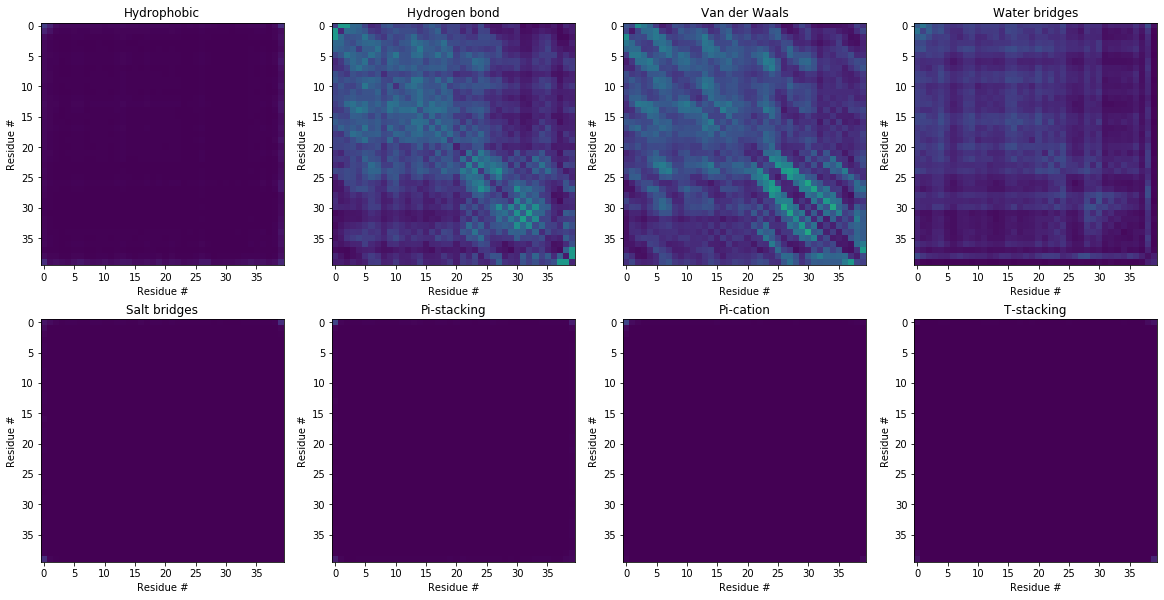

In [9]:
# Plot the predictions
preds = triu_expand(torch.from_numpy(acts['preds'])).sigmoid()
plot_channels(preds)

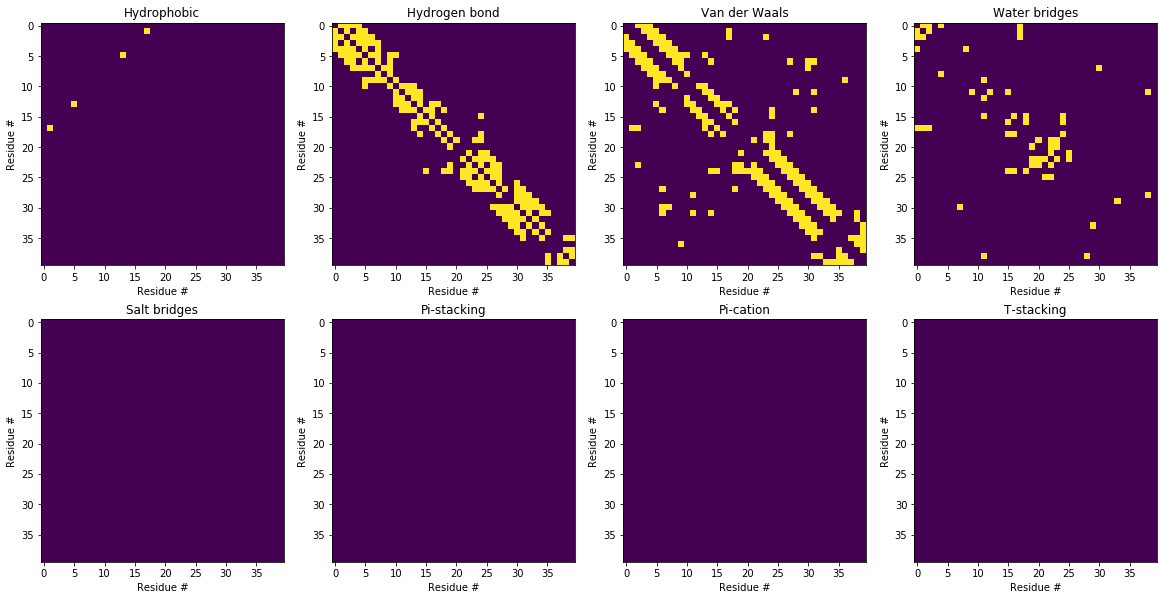

In [10]:
# Plot the true values
plot_channels(x['res_contact'])

## ROC

/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


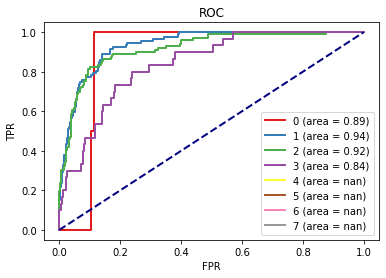

In [13]:
plot_curve(torch.from_numpy(acts['preds']).sigmoid(), triu_condense(x['res_contact'].squeeze()), 'ROC')

## PRC

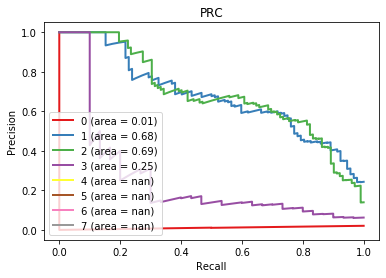

In [12]:
plot_curve(torch.from_numpy(acts['preds']).sigmoid(), triu_condense(x['res_contact'].squeeze()), 'PRC')